In [1]:
import numpy as np
from itertools import product
import pandas as pd
import random
from collections import defaultdict
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class TicTacToe():
    def __init__(self,player = 'X',reward_type ='goal_reward'):
        '''
        player: Role agent should play. If X, agent has the first turn else agent has second turn
        reward_type: 'goal_reward' or 'action_penalty'
        '''
        self.board = np.array(['__']*9).reshape(3,3)
        self.reward_type = reward_type
        self.winning_seqeunce = None #Keep track of winning move made by agent
        self.first_move = None #Keep track of first move made by agent
        if player == 'X':
            self.me ='X'
            self.id = 1
            self.opponent = 'O'
        else:
            self.me = 'O'
            self.id = 2
            self.opponent = 'X'
     
        self.game_over = False #Flag indicating whether game is over
        # Mapping of action representaion in board to action representation in tuple 
        self.b_to_s = {'__':0,'X':1,'O':2} 
        # Mapping of action representaion in tuple to action representation in board
        self.s_to_b = {0:'__',1:'X',2:'O'} 
        
        #Create mapping from 2D position in board to 1D position in tuple
        positions = self.available_positions()
        self.b2_to_s1 = {position:i for (i,position) in enumerate(positions)}
        
        #Create mapping from 1D position in tuple to 2D position in board 
        self.s1_to_b2 = {i:position for (i,position) in enumerate(positions)}
        
        #State the current player is in
        self.starting_state = self.board_to_state()
        
        #Initialize all possible states of the game
        l_o_l = [list(range(3)) for _ in range(9)]
        states = set(product(*l_o_l))
        

        
        #Player X states include states with odd number of blanks and both players have occupied equal number of slots
        #Player O playes after Player X, so player O states include states with even number of blanks and where
        #player X has occupied one more slot than player O
        playerX_states = {state for state in states if (state.count(0)%2 == 1 and state.count(1)==state.count(2))} #
        playerO_states =  {state for state in states if (state.count(0)%2 == 0 and state.count(1)==(state.count(2)+1))}
        
        #States 
        #self.board_full_states = {state for state in states if state.count(0)==0}
        if player == 'X':
            self.my_states = playerX_states
        else:
            self.my_states = playerO_states
          
    
    def reset_board(self):
        "Function to reset game and reset board to starting state"
        self.board = np.array(['__']*9).reshape(3,3)
        self.starting_state = self.board_to_state()
        self.game_over = False
        self.winning_sequence = None
        self.first_move = None
    
    def show_board(self):    
        "Shows board as a pandas dataframe"
        return pd.DataFrame(self.board)
    
    def board_to_state(self):
        "Convert a board to a state in tuple format"
        return tuple([self.b_to_s[x] for x in np.ravel(self.board)])
    
    @staticmethod
    def possible_actions(state):
        "Return possible actions given a state"
        return [i for i,x  in enumerate(state) if x ==0]
    

        
    def is_game_over(self):
        "Function to check if game is over"
        if not np.any(self.board == '__') :
            self.game_over = True
            
        return self.game_over
    
    def available_positions(self):
        "Return available positions on the board"
        x,y = np.where(self.board =='__')
        return[(x,y) for x,y in zip(x,y)]
    
    
    def win(self,player):
        "Check if player won the game and record the winning sequence"
        if np.all(self.board[0,:] == player):
            self.winning_sequence = 'R1'
        elif np.all(self.board[1,:] == player): 
            self.winning_sequence = 'R2'
        elif np.all(self.board[2,:] == player):
            self.winning_sequence = 'R3'
        elif np.all(self.board[:,0] == player):
            self.winning_sequence = 'C1'
        elif np.all(self.board[:,1] == player):
            self.winning_sequence = 'C2'
        elif np.all(self.board[:,2] == player):
            self.winning_sequence = 'C3'
        elif np.all(self.board.diagonal()==player):
            self.winning_sequence = 'D1'
        elif  np.all(np.fliplr(self.board).diagonal()==player):
            self.winning_sequence = 'D2'
        else:
            return False
        
        return True
    
    
    def my_move(self,position):
        "Fills out the board in the given position with the action of the agent"
        
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.me
        
        I_win = self.win(self.me)
        opponent_win = self.win(self.opponent)
        
        if self.reward_type == 'goal_reward':
            if I_win:
                self.game_over = True
                return 1
            
            elif opponent_win:
                self.game_over = True
                return -1
            
            else:
                return 0
            
        elif self.reward_type == 'action_penalty':
            if I_win:
                self.game_over = True
                return 0
            
            elif opponent_win:
                self.game_over = True
                return -10
            
            else:
                return -1
    
    def opponent_move(self,position):
        "Fills out the board in the given position with the action of the opponent"
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.opponent
            

#     def get_action(self,next_state):
#         " return action that will take agent to the specified next state"
#         current_state = self.board_to_state()
#         return [i for (i,j) in enumerate(current_state) if current_state[i]==0 and next_state[i]==self.id][0]
        
        
    
    def pick_best_action(self,Q,action_type,eps=None):
        '''Given a Q function return optimal action
        If action_type is 'greedy' return best action with ties broken randomly else return epsilon greedy action
        '''
        #Get possible actions
        current_state = self.board_to_state()
        actions =  self.possible_actions(current_state)
        
        best_action = []
        best_action_value = -np.Inf
        
        for action in actions:
            Q_s_a = Q[current_state][action]
            if Q_s_a == best_action_value:
                best_action.append(action)
            elif Q_s_a > best_action_value:
                best_action = [action]
                best_action_value = Q_s_a
        best_action = random.choice(best_action)

        if action_type == 'greedy':
            return self.s1_to_b2[best_action]
        else:
            assert eps != None , "Include epsilon parameter"
            n_actions =len(actions) #No of legal actions 
            p = np.full(n_actions,eps/n_actions)
            #Get index of best action
            best_action_i = actions.index(best_action)
            p[best_action_i]+= 1 - eps
            return self.s1_to_b2[np.random.choice(actions,p=p)]

In [9]:
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')

In [10]:
t_board_X.show_board()

,0,1,2
0,__,__,__
1,__,__,__
2,__,__,__


In [11]:

t_board_X.my_move((0,0))
t_board_X.show_board()

,0,1,2
0,X,__,__
1,__,__,__
2,__,__,__


In [12]:

t_board_X.opponent_move((0,1))
t_board_X.show_board()

,0,1,2
0,X,O,__
1,__,__,__
2,__,__,__


In [13]:
def play_games(n_games, Q_X, Q_O, X_strategy = 'eps_strategy', O_strategy = 'eps_strategy', eps_X = 0.05, eps_O = 0.05, seed = 1):
    """ Function to play tic tac toe specified no of times, and return summary of win statistics
        n_games: No of times to play the game
        Q_X: Q function for player X that gives X's policy
        Q_O: Q function for player O that gives O's policy
        X_strategy: eps_greedy or greedy
        O_strategy: eps_greedy or greedy
        
    """
    np.random.seed(seed)
    win_stats = defaultdict(int)
    #list to hold winnign sequences
    winning_sequences_X = []
    winning_sequences_O = []

    #list of final boards
    final_boards = []

    t_board_X = TicTacToe(player = 'X', reward_type = 'action_penalty')
    t_board_O = TicTacToe(player = 'O', reward_type = 'action_penalty')
    X_first_actions = []
    O_first_actions = []
    winning_X_first_actions = []
    winning_O_first_actions = []

    for i in tqdm(range(ngames), position = 0, leave = True):
        first_action_flag = True
        while True:
            x_action = t_board_X.pick_best_action(Q_X, action_type=X_strategy, eps = eps_X)
            if first_action_flag == True:
                X_first_actions.append(x_action)

            t_board_X.my_move(x_action)
            t_board_O.opponent_move(x_action)
            if t_board_X.is_game_over():
                break

            o_action = t_board_O.pick_best_action(Q_O, action_type = O_strategy, eps = eps_O)
            if first_action_flag == True:
                O_first_actions.append(o_action)
                first_action_flag = False
            t_board_O.my_move(o_action)
            t_board_X.opponent_move(o_action)
            if t_board_O.is_game_over():
                break

        if t_board_X.win('X'):
            win_stats['X_win'] += 1
            winning_sequences_X.append(t_board_X.winning_sequence)
            winning_X_first_actions.append(X_first_actions[-1])
        elif t_board_X.win('O'):
            win_stats['O_win'] += 1
            winning_sequences_O.append(t_board_O.winning_sequence)
            winning_O_first_actions.append(O_first_actions[-1])
        else:
            win_stats['Draw'] += 1

        final_boards.append(t_board_X.show_board())
        t_board_X.reset_board()
        t_board_O.reset_board()

    return win_stats,final_boards,winning_sequences_X,winning_sequences_O,X_first_actions,
    O_first_actions,winning_X_first_actions,winning_O_first_actions

In [14]:
def initialize_Q(S,seed = 1):
    "Given a state assign random values to each possible action"
    np.random.seed(seed)
    Q = {}
    for state in S:
        Q[state]= {}
        for i,x  in enumerate(state): # Loop through action
            if x == 0:
                Q[state][i] = np.random.rand()
    
    return Q

In [15]:

def moving_average(x, w):
    "Function to calculate moving average of rewards"
    return np.convolve(x, np.ones(w), 'valid') / w

In [16]:
def train(n_games=1000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False,is_random=True,**kwargs):
    """
    Function to train a player in a game of tic-tac-toe
    Arguments:
        n_games: Number of games on which to train
        alpha: Learning rate
        gamme: discount factor
        train_X: Flag indicating whether player X should be trained
        train_O: Flag inficating whether player O should be trained
        is_random: should actions of untrained agent be random or deterministic according to Q table
    
    """
     
    
    # If Q is not provided, randomize intially, if provided, it will be used to select actions greedily
    if "Q_X" in kwargs:
        action_type_X = "greedy"
        assert train_X == False ,"Train flag should be set to False if Q table is being provided"
        Q_X = kwargs["Q_X"]
    else:
        Q_X = initialize_Q(States_X)
        
    if "Q_O" in kwargs:
        action_type_O = "greedy"
        assert train_O == False ,"Train flag should be set to False if Q table is being provided"
        Q_O = kwargs["Q_O"]
    else:
        Q_O = initialize_Q(States_O)
    
    
    #Set epsilon value conditional on whether we are training X or O
    eps_ = lambda flag,i: 0.05*0.99**i if flag else 1.0
    
    
    #Lists to keep track of rewards earned by both players during training
    
    rewards_X = []
    rewards_O = []
    
    
    if train_X:
        X_action_type = 'eps_greedy'
    else:
        X_action_type = 'greedy'
        if is_random:
            X_action_type = 'eps_greedy'
        
            
    
    if train_O:
        O_action_type = 'eps_greedy'
    else:
        O_action_type = 'greedy'
        if is_random:
            O_action_type = 'eps_greedy'
            
    for i in tqdm(range(n_games),position=0,leave=True):
        
        eps = 0.05*0.99**i
        t_board_X.reset_board()
        t_board_O.reset_board()

        #X lands on empty board
        S_X = t_board_X.board_to_state()
        
        #X plays first
        eps = eps_(train_X,i)
        
            
        x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
        x_action1d = t_board_X.b2_to_s1[x_action]
        
        R_X = t_board_X.my_move(x_action) # make move on X's board
        t_board_O.opponent_move(x_action) # make same move on O's board

        while not (t_board_X.is_game_over() or t_board_O.is_game_over()):
            S_O = t_board_O.board_to_state()
            
            #O plays second
            eps = eps_(train_O,i)
            
            
            o_action = t_board_O.pick_best_action(Q_O,action_type=O_action_type,eps=eps)
            o_action1d = t_board_O.b2_to_s1[o_action]
            R_O = t_board_O.my_move(o_action) #make move on O's board
            t_board_X.opponent_move(o_action) #make same move on X's board
            if  t_board_O.is_game_over(): 
                #need to end game here if O makes the winnng move and add a reward 
                if train_O:
                    Q_O[S_O][o_action1d] += alpha*(R_O + 0 - Q_O[S_O][o_action1d]) # 0 given value of terminal state is 0
                
                if train_X:
                #Need to penalize X's previous action if game is over
                    Q_X[S_X][x_action1d] += alpha*(-R_O + 0 - Q_X[S_X][x_action1d]) 
                
                rewards_O.append(R_O)
                rewards_X.append(-R_O)
                break
            
            S_X_new = t_board_X.board_to_state() #Get new state
            #Calculate max_a Q_X(S',a)
            if train_X:
                x_action_ = t_board_X.pick_best_action(Q_X,action_type = 'greedy',eps=0.05) #best action from S_new
                x_action_1d = t_board_X.b2_to_s1[x_action_]
                Q_X[S_X][x_action1d]+= alpha*(R_X + gamma*Q_X[S_X_new][x_action_1d] - Q_X[S_X][x_action1d])
        
            S_X = S_X_new
    
            

            # X plays next
            eps = eps_(train_X,i)
            x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
            x_action1d = t_board_X.b2_to_s1[x_action]
            R_X = t_board_X.my_move(x_action) #make move on X's board
            t_board_O.opponent_move(x_action) #make same move on O's board

            if t_board_X.is_game_over(): 
                if train_O:
                    #need to end game here if X makes the winning move and make sure O's action is penalized
                    Q_O[S_O][o_action1d] += alpha*(-R_X + 0 - Q_O[S_O][o_action1d]) #0 given value of terminal state is 0
                
                if train_X:
                    #need to end game here if X makes the winning move and make sure reward is added to V
                    Q_X[S_X][x_action1d] += alpha*(R_X + 0 - Q_X[S_X][x_action1d]) #0 given value of terminal state is 0
                
                rewards_X.append(R_X)
                rewards_O.append(-R_X)
                break   


            S_O_new = t_board_O.board_to_state() #Get new state
            #Calculate max_a Q_O(S',a)
            if train_O:
                o_action_ = t_board_O.pick_best_action(Q_O,action_type = 'greedy',eps=0.05) #best action from S_new
                o_action_1d = t_board_O.b2_to_s1[o_action_]
                Q_O[S_O][o_action1d]+= alpha*(R_O + gamma*Q_O[S_O_new][o_action_1d] - Q_O[S_O][o_action1d])

            S_O = S_O_new
            
    if train_X:
        rewards = rewards_X
    elif train_O:
        rewards = rewards_O
        
    sns.set(font_scale=1)
    m_avg = moving_average(rewards,w=200)
    sns.lineplot(x=range(len(m_avg)),y=m_avg).set_title('Learning Curve')
    plt.show()
        
    return Q_X,Q_O,rewards_X,rewards_O


In [17]:

t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')

In [18]:
States_X = t_board_X.my_states
States_O = t_board_O.my_states

100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:49<00:00, 141.85it/s]
C:\Users\singl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\singl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\singl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sin

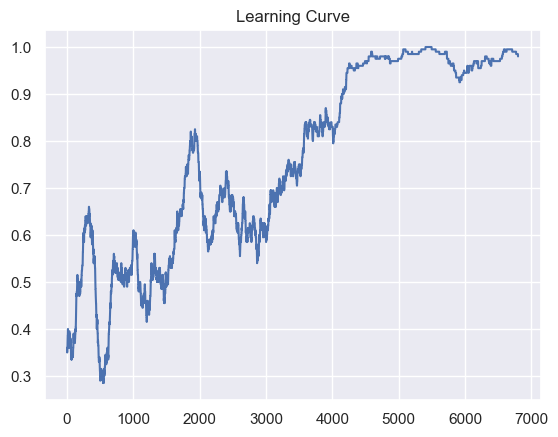

In [19]:
np.random.seed(1)
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
Q_X,_,rewards_X,rewards_O = train(n_games=7000,alpha = 0.7, gamma = 0.9,train_X=True,train_O=False,is_random=True)
Q_X_trained = Q_X

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:09<00:00, 154.55it/s]
C:\Users\singl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\singl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\singl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sin

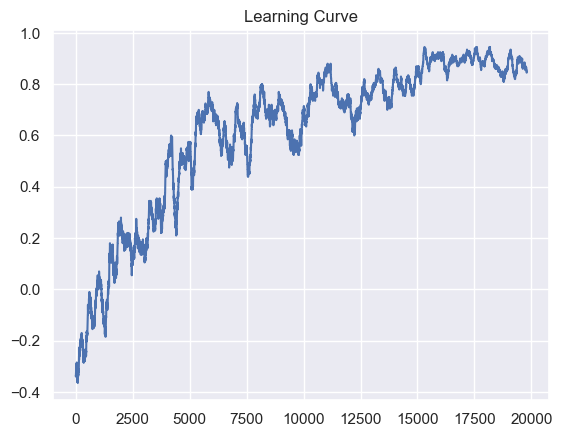

In [20]:

np.random.seed(1)
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
_,Q_O,rewards_X,rewards_O = train(n_games=20000,alpha = 0.8, gamma = 0.5,train_X=False,train_O=True,is_random=True)
Q_O_trained = Q_O

In [21]:
def test_trained_agent(Q_X, Q_O, player_type='X'):
    """
    Function to test the trained Q-learning agent.
    Arguments:
        Q_X: Trained Q-table for player X
        Q_O: Trained Q-table for player O
        player_type: The agent the user wants to play as ('X' or 'O')
    """
    # Initialize the game with the user as the selected player (X or O)
    board = TicTacToe(player=player_type)

    # Assign the appropriate Q-table for the user and the agent
    if player_type == 'X':
        user_agent = 'X'
        computer_agent = 'O'
        user_Q = Q_X
        computer_Q = Q_O
    else:
        user_agent = 'O'
        computer_agent = 'X'
        user_Q = Q_O
        computer_Q = Q_X

    def display_board():
        # Function to print the current board
        print("\nCurrent Board:")
        print(board.show_board())

    def user_move():
        # Function to take input from the user for their move
        while True:
            try:
                row, col = map(int, input(f"Enter your move ({user_agent}), row and column (0, 1, 2): ").split())
                if board.board[row, col] == '__':
                    return (row, col)
                else:
                    print("That spot is already taken. Try again.")
            except (ValueError, IndexError):
                print("Invalid input. Enter row and column as two space-separated integers (0, 1, or 2).")

    def computer_move(Q, agent):
        # Check if there are possible actions left
        current_state = board.board_to_state()
        possible_actions = board.possible_actions(current_state)
        
        if not possible_actions:  # No possible moves left
            return None

        # Function to let the computer make a move based on the trained Q-table
        action = board.pick_best_action(Q, action_type='greedy')
        print(f"\nComputer ({agent}) played at: {action}")
        return action

    display_board()

    # Main game loop
    while not board.is_game_over():
        # User's turn
        if board.me == user_agent:
            move = user_move()
            board.my_move(move)
            display_board()

            # Check if user won the game
            if board.win(user_agent):
                print(f"Congratulations! {user_agent} wins!")
                break

            # Computer's turn
            move = computer_move(computer_Q, computer_agent)
            if move is None:
                print("No moves left! It's a draw.")
                break
            board.opponent_move(move)
            display_board()

            # Check if computer won the game
            if board.win(computer_agent):
                print(f"Sorry, {computer_agent} wins!")
                break

        # Computer plays first if user is O
        else:
            move = computer_move(computer_Q, computer_agent)
            if move is None:
                print("No moves left! It's a draw.")
                break
            board.opponent_move(move)
            display_board()

            # Check if computer won the game
            if board.win(computer_agent):
                print(f"Sorry, {computer_agent} wins!")
                break

            # User's turn
            move = user_move()
            board.my_move(move)
            display_board()

            # Check if user won the game
            if board.win(user_agent):
                print(f"Congratulations! {user_agent} wins!")
                break

    # If the game is over and no one won, it's a draw
    if not board.win(user_agent) and not board.win(computer_agent):
        print("It's a draw!")


In [22]:
import tkinter as tk
from tkinter import messagebox

class TicTacToeGUI:
    def __init__(self, Q_X, Q_O, player_type='X'):
        self.window = tk.Tk()
        self.window.title("Tic Tac Toe vs AI")
        
        # Set up window close protocol
        self.window.protocol("WM_DELETE_WINDOW", self.on_closing)
        
        # Initialize the game with existing TicTacToe class
        self.game = TicTacToe(player=player_type)
        
        # Store Q-tables and player types
        if player_type == 'X':
            self.user_agent = 'X'
            self.computer_agent = 'O'
            self.computer_Q = Q_O
        else:
            self.user_agent = 'O'
            self.computer_agent = 'X'
            self.computer_Q = Q_X
        
        # Create the buttons grid
        self.buttons = [[None for _ in range(3)] for _ in range(3)]
        for i in range(3):
            for j in range(3):
                self.buttons[i][j] = tk.Button(
                    self.window,
                    text="",
                    width=10,
                    height=3,
                    command=lambda row=i, col=j: self.handle_click(row, col)
                )
                self.buttons[i][j].grid(row=i, column=j)
        
        # If computer starts (when player is O), make the first move
        if player_type == 'O':
            self.make_computer_move()
    
    def on_closing(self):
        """Handle window closing event"""
        if messagebox.askokcancel("Quit", "Do you want to quit the game?"):
            self.window.destroy()
    
    def update_display(self):
        """Update the GUI to match the game board"""
        for i in range(3):
            for j in range(3):
                value = self.game.board[i, j]
                self.buttons[i][j].config(text=value if value != '__' else '')
    
    def handle_click(self, row, col):
        """Handle player clicks on the board"""
        # Check if the cell is empty and it's player's turn
        if self.game.board[row, col] == '__' and not self.game.is_game_over():
            # Make player's move
            self.game.my_move((row, col))
            self.update_display()
            
            # Check if game is over after player's move
            if self.game.win(self.user_agent):
                messagebox.showinfo("Game Over", f"Congratulations! {self.user_agent} wins!")
                self.window.destroy()
                return
            elif self.game.is_game_over():
                messagebox.showinfo("Game Over", "It's a draw!")
                self.window.destroy()
                return
            
            # Make computer's move
            self.make_computer_move()
    
    def make_computer_move(self):
        """Make the computer's move using the existing game logic"""
        current_state = self.game.board_to_state()
        possible_actions = self.game.possible_actions(current_state)
        
        if not possible_actions:
            messagebox.showinfo("Game Over", "It's a draw!")
            self.window.destroy()
            return
        
        # Use existing pick_best_action method
        action = self.game.pick_best_action(self.computer_Q, action_type='greedy')
        self.game.opponent_move(action)
        self.update_display()
        
        # Check if game is over after computer's move
        if self.game.win(self.computer_agent):
            messagebox.showinfo("Game Over", f"Computer ({self.computer_agent}) wins!")
            self.window.destroy()
            return
        elif self.game.is_game_over():
            messagebox.showinfo("Game Over", "It's a draw!")
            self.window.destroy()
            return

def test_trained_agent_gui(Q_X, Q_O, player_type='X'):
    """
    GUI version of test_trained_agent function.
    Arguments:
        Q_X: Trained Q-table for player X
        Q_O: Trained Q-table for player O
        player_type: The agent the user wants to play as ('X' or 'O')
    """
    game = TicTacToeGUI(Q_X, Q_O, player_type)
    game.window.mainloop()

In [23]:
test_trained_agent_gui(Q_X_trained, Q_O_trained, player_type='O')  # or player_type='O'